# **Going Deeper -- the Mechanics of PyTorch (Part 1/3)**

### **The Key features of PyTorch**

### **PyTorch’s computation graphs**

- computation based on a `directed acyclic graph (DAG)`

#### **Understanding computation graphs**

- Each node resembles an operation, which applies a function to its input tensor or tensors and returns zero or more tensors as the output.
- Uses computation graph to compute the gradients accordingly.

#### Creating a graph in PyTorch

- $z = 2 \times (a - b) + c$
- a, b, and c are scalars (single numbers), defined as PyTorch tensors.

In [1]:
import torch

def compute_z(a: float, b: float, c: float):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [2]:
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


#### **PyTorch Tensor objects for storing and updating model parameters**

- tensor object for which gradients need to be computed allows us to store and update the parameters of our models during training.
- such tensors are created by assigning `requires_grad` to `True` on user-specified initial values.

In [14]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

tensor(3.1400, requires_grad=True)


In [19]:
a.requires_grad

True

In [15]:
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


In [20]:
b.requires_grad

True

- by default `requires_grad` is set to `False`, this value can be efficiently set to `True` by running `requires_grad_()`.

In [17]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)

False


In [18]:
w.requires_grad_()
print(w.requires_grad)

True


- `Glorot initialization` a classic random initialization scheme.
- create an empty tensor and an operator called `init` as an object of class `GlorotNormal`.
- fill tensor with values, by calling the `xavier_normal_()` method.

In [5]:
import torch.nn as nn 

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [22]:
w.shape

torch.Size([2, 3])

In [23]:
nn.init.xavier_uniform_(w)
print(w)

tensor([[ 0.4001, -0.4269, -0.0799],
        [-0.0986,  0.1588, -0.0044]])


### **Xavier (Glorot) Initialization**

The goal of **Xavier (Glorot) initialization** is to maintain a stable variance of activations and gradients as they propagate forward and backward through a neural network. This avoids the problems of activations exploding or vanishing, especially in deep architectures.


**Key Idea**

When initializing weights, choose them so that:

* The **variance of activations** stays the same across layers.
* The **variance of gradients** stays the same across layers.

Given a layer with:

* $( n_{in} )$: number of input units
* $( n_{out} )$: number of output units



**Xavier Uniform Initialization**

Weights are drawn from:


$$W \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{in} + n_{out}}},\sqrt{\frac{6}{n_{in} + n_{out}}}\right)$$



**Xavier Normal Initialization**

Weights are drawn from:


$$W \sim \mathcal{N}\left(0,\frac{2}{n_{in} + n_{out}}\right)$$




**When to Use**

* Best suited for **tanh** and **sigmoid** activation functions.
* For **ReLU**, **Kaiming/He initialization** is usually preferred because ReLU drops half the variance by zeroing negative values.



**Intuition**

If weights are too large → forward activations and gradients blow up.
If too small → they vanish as depth increases.

Xavier balances these by ensuring:


$$\mathrm{Var}[W] = \frac{2}{n_{in} + n_{out}}$$


which keeps activations and gradients stable across layers.


- to put this into the context of a more practical use case, let's see how we can define two `Tensor` objects inside the base `nn.Module` class:

In [26]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

- These two tensors can be then used as weights whose gradients will be computed via `automatic differentiation`.

---

### **Computing gradients via automatic differentiation**

- optimizing `NNs` requires computing the gradients of the loss with respoect to the `NN` weights.
- Required for optimization algorithms such as `stochastic gradient descent (SGD)`.

#### **Computing the gradients of the loss with respect to trainable variables**

- PyTorch supports `automatic differentiation`.
- chain rule for computing gradients of nested functions.
- `gradient` refers to both partial derivatives and gradients
- call the `backward` method from `torch.autograd` module in PyTorch to compute these gradients.
- computes the sum of gradients of the given tensor with regard to leaf nodes (terminal nodes) in the graph.


- compute loss as sum of the squared error, Loss = $\sum_{i}(y_{i} - z{i})^{2}$
- model parameters, $w$ and $b$, as variables (requires gradient)
- input, $x$ and $y$, as defualt tensors.
- compute loss tensor and use it to compute the gradients of the model parameters, $w$ and $b$, as follows:

In [31]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])

z = torch.add(torch.mul(w, x), b)

loss = (y - z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)

dL/dw :  tensor(-0.5600)


In [32]:
print('dL/db : ', b.grad)

dL/db :  tensor(-0.4000)


- verify that the computed gradients match the results we obtained in the previous code examples:

In [ ]:
# verifying the computed gradient
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


---

### **Simplifying implementations of common architectures via the torch.nn module**

- conjuring layers of feedforward NN model (multilayer perceptron) via `nn.Sequential`.


**Implementing models based on nn.Sequential**

- cascaded connection of model layers.
- two densely (fully) connected layers.

In [34]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

- The output of the first fully connected layer is used as the input to the first `ReLU` layer.
- The output of the first `ReLU` layer becomes the input for the second fully connected layer.
- Finally, the output of the second fully connected layer is used as the input to the second `ReLU` layer.


**Configuring layers**

- We can further configure these layers, by applying different activation functions, initializers, or regularization methods to the parameters.
- List of available options for most of these categories;
  
  - Initializers nn.init: https://pytorch.org/docs/stable/nn.init.html
  - L1 Regularizers nn.L1Loss: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
  - L2 Regularizers weight_decay: https://pytorch.org/docs/stable/optim.html
  - Activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [39]:
model[0].weight.shape, model[2].weight.shape

(torch.Size([16, 4]), torch.Size([32, 16]))

- configure the first fully connected layer by specifying the initial value distribution for the weight.
  - initialized the weight of the first linear layer with Xavier initialization.

- configure the second fully connected layer by computing the `L1` penalty term for the weight matrix.
  - L1 norm of the weight of the second linear layer.

In [40]:
nn.init.xavier_uniform_(model[0].weight)

l1_weight = 1e-2
l1_penalty = l1_weight * model[2].weight.abs().sum()

**Compiling a model**

- Optimizers torch.optim: https://pytorch.org/docs/stable/optim.html#algorithms
- Loss Functions tf.keras.losses: https://pytorch.org/docs/stable/nn.html#loss-functions

**Choosing a loss function**

- choices for optimization algorithms.
- choice of loss function depends on the task.
- MSELoss for a regression problem.
- Cross-entropy loss functions are possible choices for classification tasks.
- model evaluation;
  - precision and recall,
  - accuracy
  - area under the curve (AUC)
  - false negative and false positive scores

In [41]:
# use SGD optimizer, and cross-entropy loss for binary classification:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

---

#### **Solving an XOR classification problem**

- Toy dataset of 200 training examples with two features $(x_{0}, x_{1})$, drawn from a uniform distribution between `[-1, 1]`.
- Ground truth label for training example `i` according to the following rule:

$$
y^{(i)} = \begin{cases} 
0 & \text{if } x_{0}^{(i)} \times x_{1}^{(i)} < 0 \\
1 & \text{if } otherwise
\end{cases}
$$

- use half of the data for training and remaining half for validation.

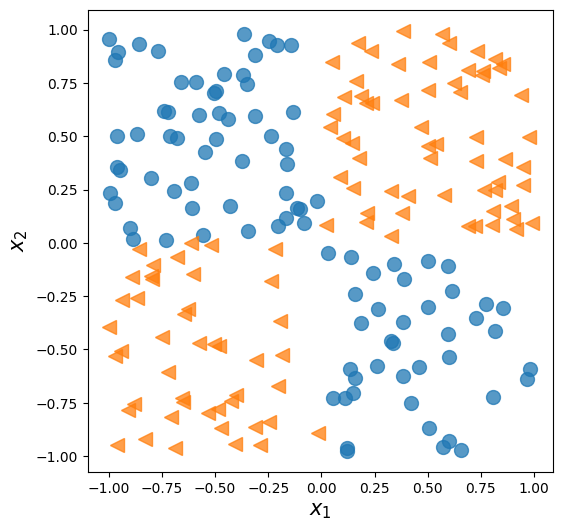

In [2]:
# Data generation and splitting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)


fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)

plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)

plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

#plt.savefig('figures/13_02.png', dpi=300)
plt.show()

In [68]:
x_train.shape, y_train.shape

(torch.Size([100, 2]), torch.Size([100]))

- Implement a classifier in PyTorch
- The more layers we have, the more neurons we have in each layer, the larger the capacity of the model will be.
- model capacity can be thought of as a measure of how readily the model can approximate complex functions.
- more parameters means that the network can fit more complex functions,
- larger models are usually harder to train (and prone to overfitting),
- Always a good practice to start with a small model as a baseline.

In [3]:
# create a data loader that uses a batch size of 2 for the train data:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [7]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [8]:
model[0].weight, model[0].weight.shape

(Parameter containing:
 tensor([[ 0.2583, -0.2756]], requires_grad=True),
 torch.Size([1, 2]))

- initialize the cross-entropy loss function for binary classification and the SGD optimizer:

In [9]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

- Train the model for 200 epochs and record a history of training epochs.

In [10]:
torch.manual_seed(1)
num_epochs = 200

def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()
            
        loss_hist_train[epoch] /= n_train
        accuracy_hist_train[epoch] /= n_train/batch_size
        
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

- includes the training and validation loss
- also includes the train and validation accuracy
- plot learning curves, including the training and validation loss, as well as their accuracies

Text(0.5, 0, 'Epochs')

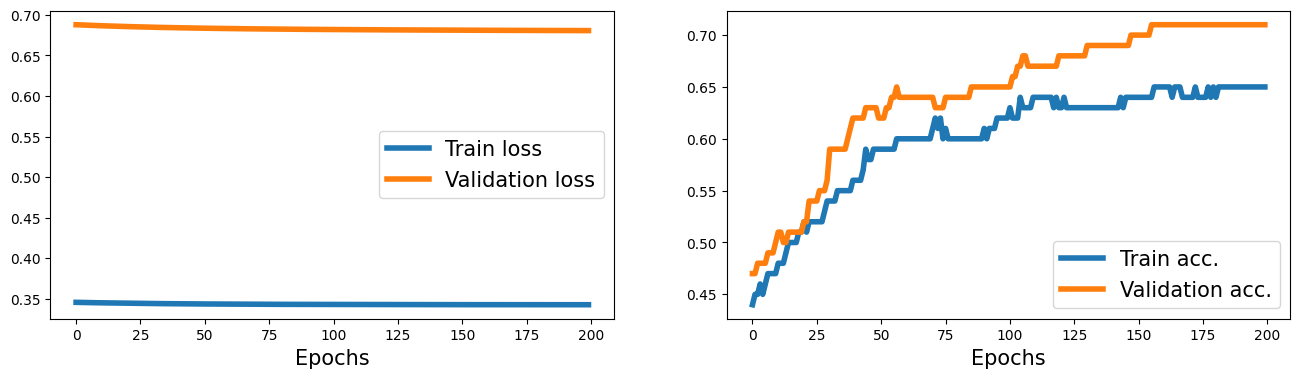

In [11]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_03.png', dpi=300)

- Our simple model has no hidden layer, which is unable to solve the `XOR` problem.

- The loss terms for the `validation datasets` are high, and the `classification accuracy` is quite low.

- To derive a nonlinear decision boundary, we can add one or more `hidden layers` connected via `nonlinear activation` functions.

- The universal approximation theorem states that a `feedforward NN` with a single hidden layer and a relatively large number of hidden units can approximate arbitrary continuous functions relatively well. 

- Thus, one approach for tackling the `XOR` problem more satisfactorily is to add a hidden layer and compare different numbers of hidden units until we observe satisfactory results on the validation dataset.

- Adding more `hidden units` would correspond to increasing the width of a layer.

- Alternatively, we can also add more `hidden layers`, which will make the model deeper.

- The advantage of making a network deeper rather than wider is that fewer parameters are required to achieve a comparable model capacity.
`
- However, a downside of deep (versus wide) models is that deep models are prone to `vanishing` and `exploding gradients`, which make them harder to train.

**Adding two hidden layers to the feedforward NN**

In [75]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [78]:
model[0].weight.shape, model[2].weight.shape, model[4].weight.shape

(torch.Size([4, 2]), torch.Size([4, 4]), torch.Size([1, 4]))

In [79]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

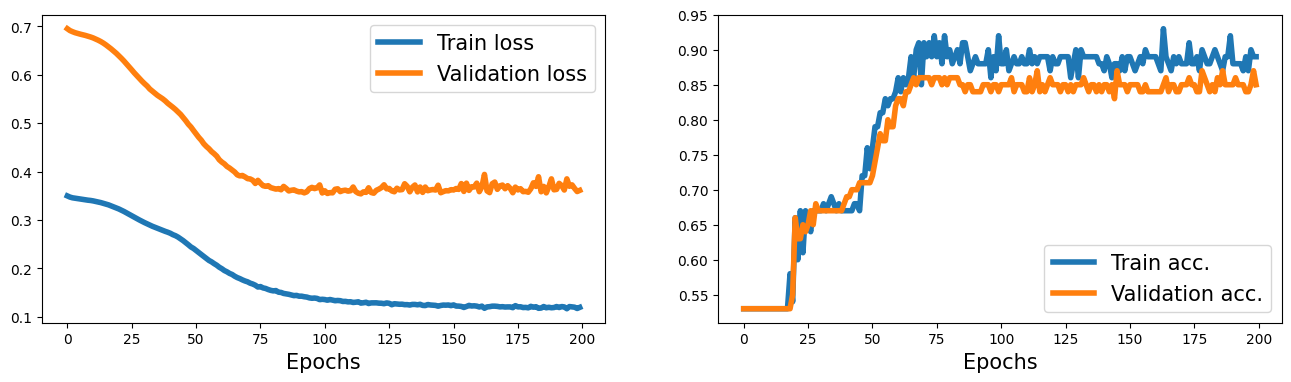

In [80]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_04.png', dpi=300)

- The model is able to derive a nonlinear decision boundary for this data.
- Though the model might be slightly overfitting.

---

### **Making model building more flexible with nn.Module**'

- `nn.Module` allows us to create more complex models that have multiple input, output, or intermediate branches.
- Alternative way to build complex models is by subclassing `nn.Module`.
- Create a new class derived from `nn.Module` and define the method `__init__()`.
- We define the layers as attributes of the class so that they can be accessed via the `self` reference attribute.
- In the `forward()` method, we specify how these layers are to be used in the forward pass of the `NN`.

In [37]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model
    

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

- we put all layers in the `nn.ModuleList` object, which is just a list object composed of `nn.Module` items.
- Makes the code more readable and easier to follow.

In [38]:
model.get_parameter

<bound method Module.get_parameter of MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)>

In [39]:
model.module_list[0].weight.shape, model.module_list[2].weight.shape

(torch.Size([4, 2]), torch.Size([4, 4]))

In [40]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

- compute the decision boundary of our model.
- Let's add a `predict()` method in the `MyModule` class

In [22]:
# returns the predicted class (0 or 1) for a sample
# def predict(self, x):
#     x = torch.tensor(x, dtype=torch.float32)
#     pred = self.forward(x)[:, 0]
#     return (pred>=0.5).float()

- plot the training performance along with the decision region bias:

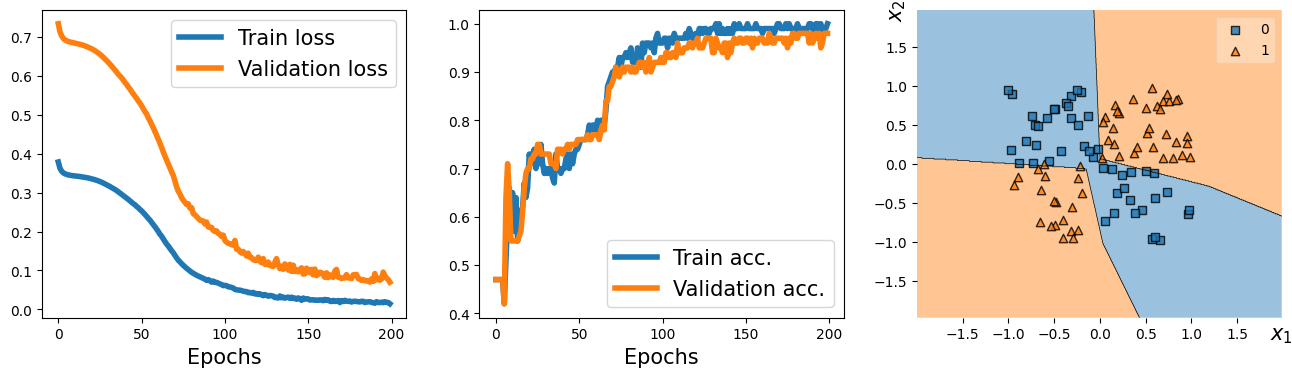

In [41]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)

ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

**Improving the Model: Regularization, Hyperparameter Tuning, and Better Architecture**

1. Use a Numerically Stable Loss
   - Remove the `Sigmoid` from the final layer.
   - Use `nn.BCEWithLogitsLoss()`.
2. Add Weight Regularization (L2)
   - Increase `weight_decay` if still overfitting.
3. Add Dropout
   - Insert `dropout` between layers to reduce co-adaptation
4. Switch Optimizer
   - Try `Adam` with a lower learning rate for smoother convergence
5. Early Stopping
   - Monitor validation loss during training
6. Early Stopping
   - Ensure your input features are standardized (zero mean, unit variance).

- **Revised model architecture**

In [42]:
import torch
import torch.nn as nn

class ImprovedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(8, 1)  # No Sigmoid here
        )

    def forward(self, x):
        return self.net(x)

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        logits = self.forward(x).squeeze(1)
        probs = torch.sigmoid(logits)
        return (probs >= 0.5).float()

model = ImprovedModel()
model

ImprovedModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

- **Loss + Optimizer (Recommended Setup)**

In [43]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-4)   # L2 regularization

**Why This Architecture Works Better**

| Change                              | Effect                                                 |
| ----------------------------------- | ------------------------------------------------------ |
| **Removed Sigmoid from last layer** | Enabled stable gradient flow using `BCEWithLogitsLoss` |
| **Increased hidden dimension to 8** | More representational power                            |
| **Added Dropout**                   | Reduces overfitting by preventing co-adaptation        |
| **Used Adam + Weight Decay**        | More stable training + L2 regularization               |

In [44]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

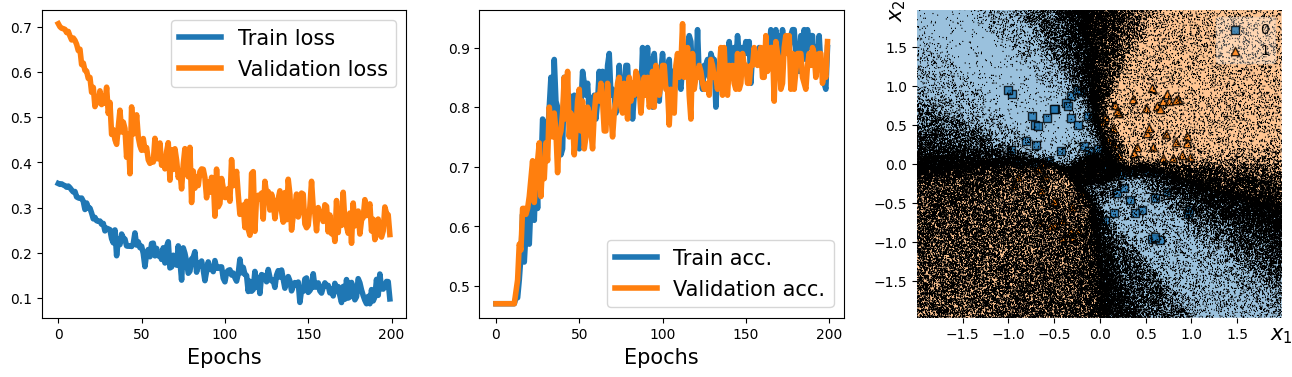

In [45]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)

ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

---

#### **Writing custom layers in PyTorch**

- Want to define a new layer that is not already supported by PyTorch, we can define a new class derived from the `nn.Module` class.
- useful when designing a new layer or customizing an existing layer.
- define a new laayer called `NoisyLinear`, which implements the computation $w(x + \epsilon) + b$

In [46]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w) # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
    
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x 
        return torch.add(torch.mm(x_new, self.w), self.b)

- `noise_stddev` specifies the standard deviation for the distribution of $\epsilon$, which is sampled from a Gaussian distribution.

- Let's use our custom `NoisyLinear` layer in a model, test it in the context of a simple example.
- Define a new instance of this layer, and execute it on an input tensor.
- Call the layer three times on the same input tensor.

In [47]:
## testing:

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
 
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)


In [48]:
print(noisy_layer(x, training=True))

tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)


In [49]:
print(noisy_layer(x, training=False))

tensor([[0., 0.]], grad_fn=<AddBackward0>)


- Note that the outputs for the first two calls difffer because the `NoisyLinear` layer added random noise to the input tensor.
- The third call outputs `[0, 0]` as we didn't add noise by specifying training=False.

- Let's create a new model similar to the previous one for solving the `XOR` classification task.
- Use the `nn.Module` class for model building, but will use our `NoisyLinear` layer as the first hidden layer of the multilayer perceptron.

**Code implementation**

In [55]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [69]:
model.l2.weight.shape, model.l3.weight.shape

(torch.Size([4, 4]), torch.Size([1, 4]))

- Train the model.
- Compute prediction on the training batch, we use `pred = model(x_batch, True)[:, 0]` instead of `pred = model(x_batch)[:, 0]`:

In [70]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

- After the model is trained, we can plot the losses, accuracies, and the decision boundary:

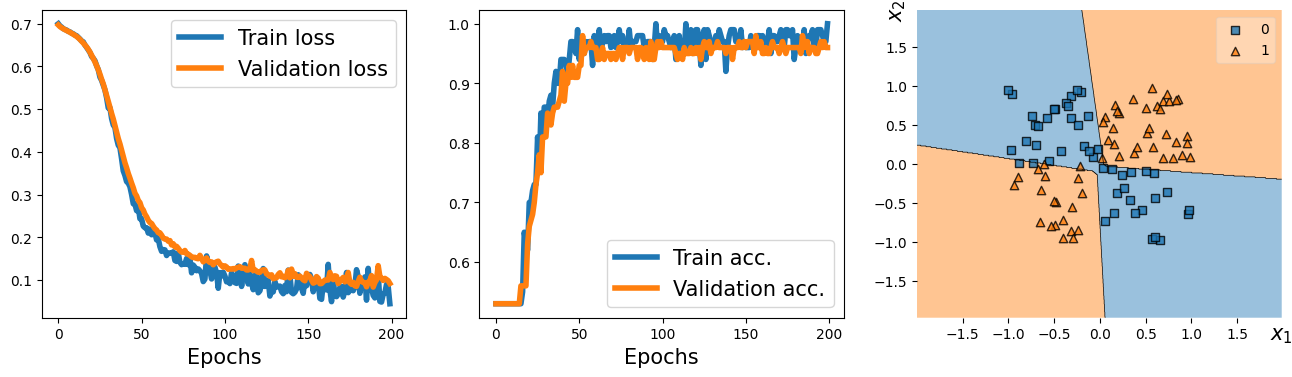

In [ ]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)

ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_06.png', dpi=300)
plt.show()

- Our goal here was to learn how to define a new custom layer subclasses from `nn.Module` and to use it as we would use any other standard `torch.nn` layer.
- Objective was to learn how to write a customized layer from scratch.
- Can be useful in cases were you develop a new algorithm that depends on a new layer bryond the existing ones.